In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database
! unzip "covid19-radiography-database.zip"

In [ ]:
! pip install "torch==1.4" "torchvision==0.5.0"

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np 
import zipfile

import matplotlib.pyplot as plt
import time
import os

In [5]:
from fastai.callbacks import ActivationStats
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [6]:
classes = ['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [7]:
bs = 128

In [8]:
path = Path('/content/COVID-19 Radiography Database/')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.35,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.classes

['COVID-19', 'NORMAL', 'Viral Pneumonia']

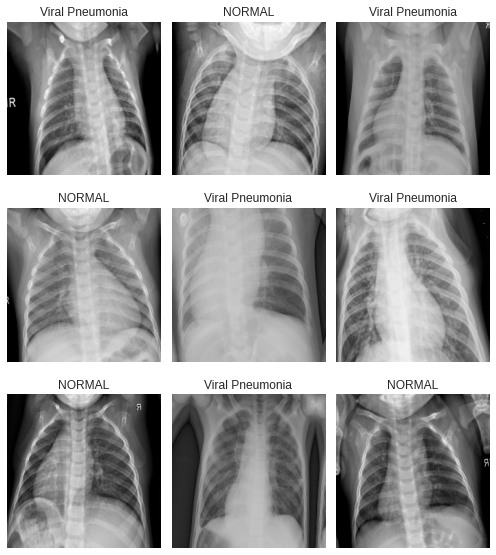

In [11]:
data.show_batch(rows=3, figsize=(7,8))

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID-19', 'NORMAL', 'Viral Pneumonia'], 3, 1889, 1016)

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.726588,1.166902,0.731299,19:35
1,0.542908,0.340219,0.926181,20:09
2,0.392431,0.272458,0.930118,20:29
3,0.320939,0.255424,0.937008,20:12


In [ ]:
# Save the model
learn.save('stage-1')
# Load the Model
learn.load('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-07


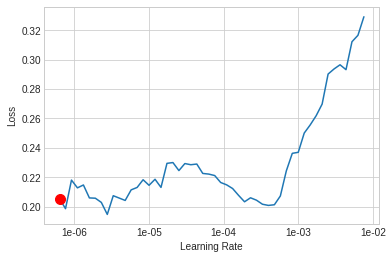

In [15]:
# Unfreeze all layers of the CNN
learn.unfreeze()
# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
# Fit the model over 2 epochs
learn.fit_one_cycle(2, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.257015,1.049824,0.865157,26:16
1,0.196822,0.194695,0.953740,26:16


In [17]:
learn.export(file = Path("covid.pkl"))

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

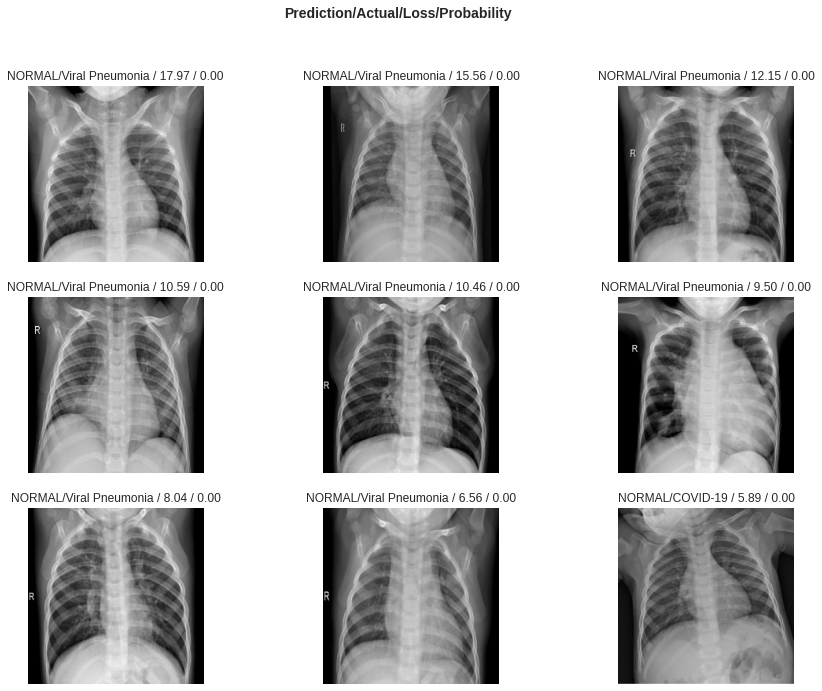

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

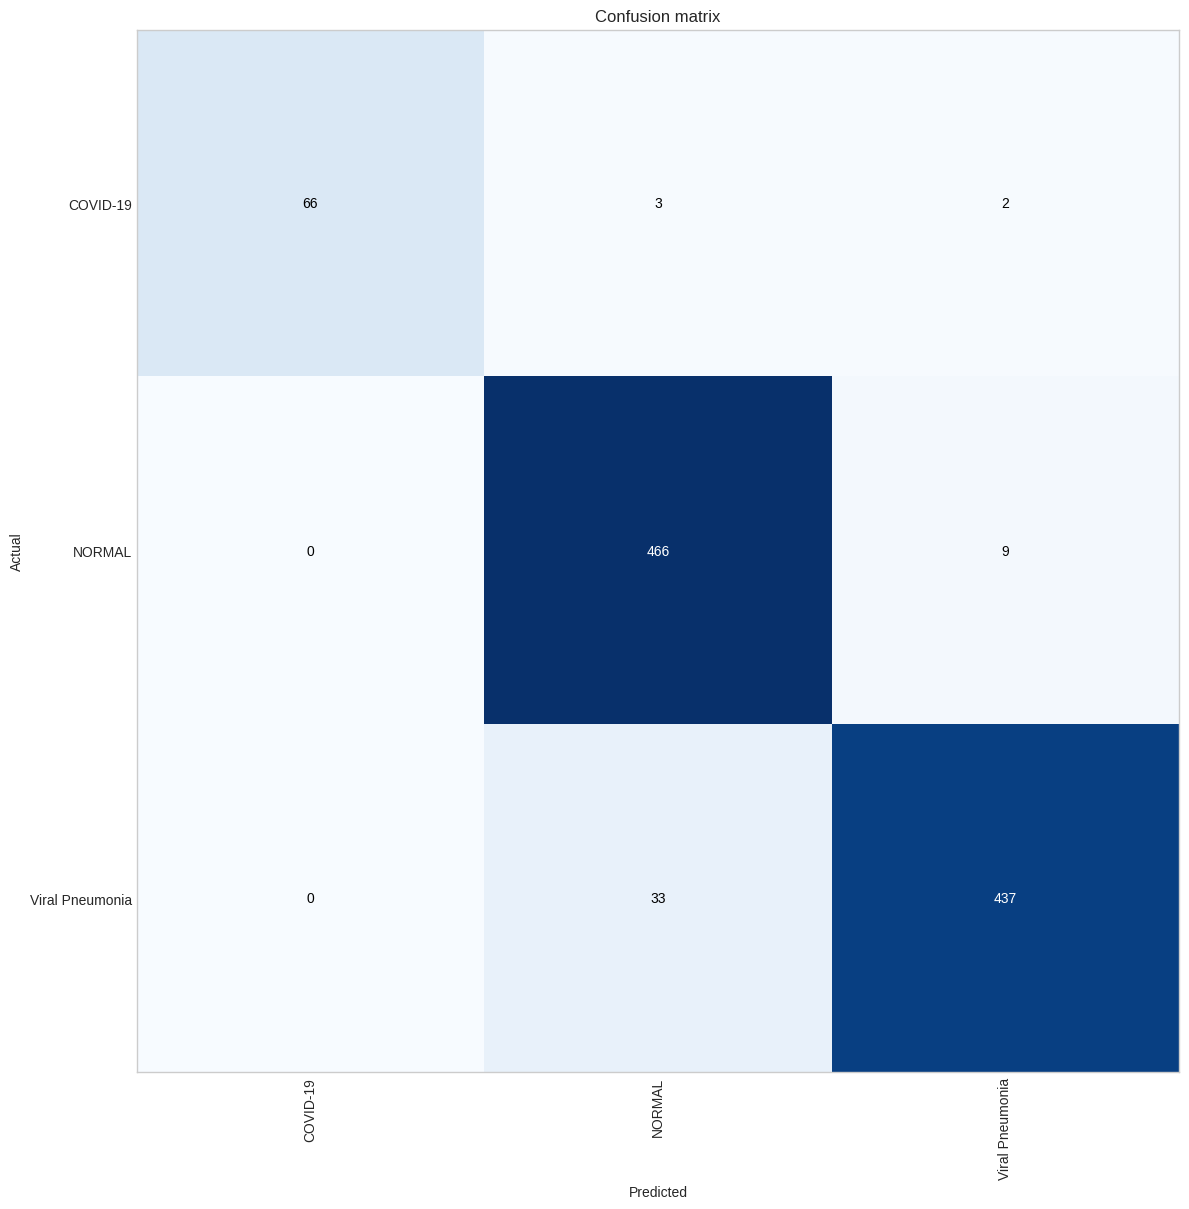

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=100)

In [39]:
img = open_image('/content/COVID-19 Radiography Database/COVID-19/COVID-19 (107).png')
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'COVID-19'